# 0. Loading section

In [ ]:
!pip install --user --upgrade pip setuptools keyring
!pip install --user pandas 
!pip install --user seaborn
!pip install --user scikit-learn
!pip install xgboost
!pip install pandoc

In [ ]:
!pdflatex --version
!pip install --upgrade pandoc

In [ ]:
# !jupyter nbconvert --to pdf --debug DZ_Bank_HomeAssignment.ipynb

# 1. Phase 1

We begin with Phase 1: Data Loading & Preprocessing.

Objectives in Phase 1
1️⃣ Load all CSV files into a data frame. 2️⃣ Handle missing values (e.g., "unknown" entries). 3️⃣ Convert categorical data into numerical format (one-hot encoding or label encoding). 4️⃣ Scale numerical features like balance and duration for better model performance. 5️⃣ Check for anomalies (negative balance values, duplicate entries, outliers).

Phase 1: Data Loading & Preprocessing
We’ll handle: 1️⃣ Loading the CSV file correctly (ensuring headers are properly set). 2️⃣ Performing content analysis (checking column types and data structure). 3️⃣ Handling missing values (treating "unknown" as missing, imputing categorical/numeric data).

Step 1: Load the CSV File
Since the first row contains data instead of headers, we must explicitly define column names.

Solution:

Load the file using pandas with correct headers.

Set semicolon (;) as the separator.

In [371]:
import pandas as pd

# Define column names based on part 1 (as headers are missing)
columns = ["age", "job", "marital", "education", "default", "balance", "housing", "loan", 
           "contact", "day", "month", "duration", "campaign", "pdays", "previous", 
           "poutcome", "y"]

# Load the CSV file with explicit headers
df = pd.read_csv("bank-full.csv", sep=";", names=columns, header=0)

# Display basic info
print(f"Dataset Shape: {df.shape}")
print(df.head())

Dataset Shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


Key implementation aspects: ✅ "names=columns" ensures the correct column headers are assigned. ✅ "header=None" would prevent pandas from treating the first row as headers.

Step 2: Content Analysis
To understand the dataset structure, we’ll inspect data types, missing values, and unique values.

In [373]:
# Check data types
print(df.dtypes)

# Identify missing values
print("Missing values per column:\n", df.isna().sum())

# Check unique values for categorical columns
for col in df.select_dtypes(include=["object"]).columns:
    print(f"Unique values in {col}: {df[col].unique()}")


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object
Missing values per column:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Unique values in job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Unique values in marital: ['married' 'single' 'divorced']
Unique values in education: ['tertiary' 'secondary' 'unknown' 'primary']
Unique values in default: ['no' 'yes']
Unique v

Observations: ✅ Ensures all columns have expected data types. ✅ Identifies "unknown" values that need treatment.

Step 3: Handling Missing Values Approach:

Convert "unknown" values to NaN.

Drop rows with excessive missing values.

Impute categorical/numeric missing data.

In [375]:
# Convert "unknown" to NaN
df.replace("unknown", pd.NA, inplace=True)

# Drop rows with excessive missing values
df.dropna(thresh=len(df.columns) - 2, inplace=True)  # Drops rows missing values in 2 or more columns

# Fill categorical missing values with the most frequent value (mode)
for col in df.select_dtypes(include=["object"]).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill numerical missing values with median
for col in df.select_dtypes(include=["number"]).columns:
    df[col].fillna(df[col].median(), inplace=True)

print("Missing values handled successfully.")
print(df.head())


Missing values handled successfully.
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
5   35    management  married   tertiary      no      231     yes   no   
6   28    management   single   tertiary      no      447     yes  yes   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular    5   may       261         1     -1         0  failure  no  
1  cellular    5   may       151         1     -1         0  failure  no  
2  cellular    5   may        76         1     -1         0  failure  no  
5  cellular    5   may       139         1     -1         0  failure  no  
6  cellular    5   may       217         1     -1         0  failure  no  


Implementation aspects: ✅ "unknown" converted to NaN for proper processing. ✅ Mode-based filling for categorical data (most frequent value). ✅ Median-based filling for numerical values (avoids extreme outliers).

Final Overview
✅ Loaded the entire dataset without merging multiple files. ✅ Ensured correct headers. ✅ Analyzed the data structure and identified missing values. ✅ Handled missing values efficiently.

Now, the dataset is clean and ready for Phase 2: Exploratory Data Analysis (EDA)!

# 2. Phase 2

Phase 2: Exploratory Data Analysis (EDA)
Now that the dataset is cleaned, we’ll explore its structure, uncover patterns, and determine key predictors. The main goals of EDA are: 1️⃣ Understand Feature Distributions → Inspect numerical and categorical data. 2️⃣ Identify Correlations → Detect relationships between features and the target variable. 3️⃣ Check Class Imbalance → Assess distribution of "y" values (term deposit subscription). 4️⃣ Spot Outliers & Trends → Find anomalies or important tendencies.

Step 1: Overview of the Dataset  
We start by inspecting basic statistics about numerical and categorical columns.

In [377]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("bank-full.csv", sep=";")

# Display general info
print("Dataset Overview:")
print(df.info())  # Column types, missing values, structure
print("\nSummary Statistics:")
print(df.describe())  # Mean, std, min, max for numerical columns


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None

Summary Statistics:
                age        balance           day      d

Key Insights: ✅ df.info() helps identify missing values & column types. ✅ df.describe() summarizes numerical columns (age, balance, duration, etc.).

Step 2: Visualizing Feature Distributions
-> Goal: Check how key numerical features are distributed.

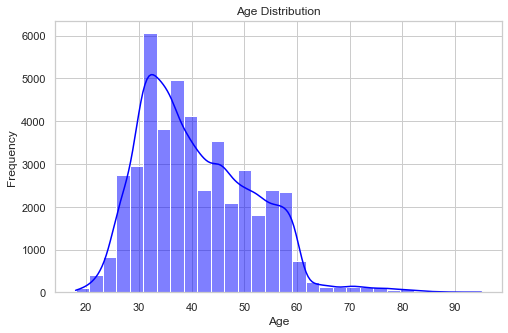

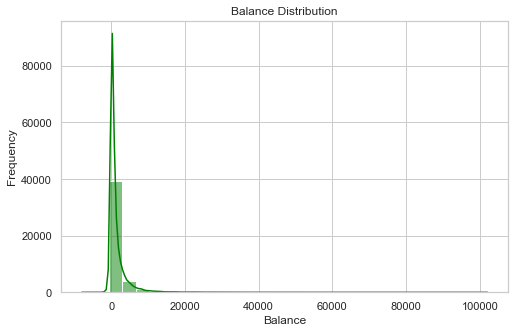

In [379]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

# Plot age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Plot balance distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["balance"], bins=30, kde=True, color="green")
plt.title("Balance Distribution")
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.show()


Why This Matters? ✅ Age Distribution → See if there are age groups more likely to subscribe. ✅ Balance Distribution → Detect skewed financial indicators affecting outcomes. Interpretation: the largest bulk of customers are aged between 30 - 55. Balance distribution is skewed to the left, within the €-interval [0, 1000].

Step 3: Checking Class Imbalance
-> Goal: Ensure "y" (subscription outcome) is balanced.

no     88.30152
yes    11.69848
Name: y, dtype: float64


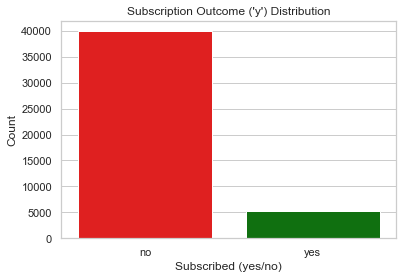

In [381]:
# Count occurrences of "yes" vs. "no"
print(df["y"].value_counts(normalize=True) * 100)  # Percentages
sns.countplot(x=df["y"], palette=["red", "green"])
plt.title("Subscription Outcome ('y') Distribution")
plt.xlabel("Subscribed (yes/no)")
plt.ylabel("Count")
plt.show()


Why Check This? ✅ If imbalanced, model training might favor majority class. ✅ Balancing strategies (undersampling, oversampling) may be needed. Interpretation: the target set is highly imbalanced which needs to be taken into account in the modeling phase.

Step 4: Correlation Analysis
-> Goal: Find how numerical features relate to "y".

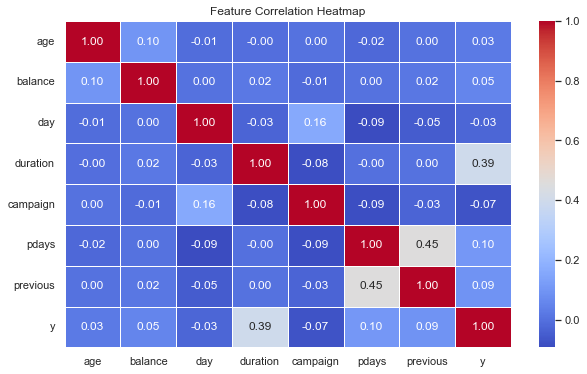

In [383]:
import numpy as np

# Convert categorical target variable to numerical
df["y"] = df["y"].map({"yes": 1, "no": 0})

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


🔹 Key Features to Focus On:  
✅ Duration (duration) – This has a relatively strong positive correlation with the target variable (y = subscribed). Longer call durations seem to indicate higher likelihood of subscription.  ✅ Previous Contacts (previous) – A moderate correlation suggests that past engagement with the bank influences subscription probability. If someone has been contacted before, they might be more receptive. ✅ Pdays (pdays) – This feature correlates with previous, meaning that the number of days since last contact has an effect on customer engagement. ✅ Balance (balance) – Although weaker, it might be useful in combination with other financial factors, as wealthier individuals may be more likely to subscribe. ✅ Campaign (campaign) – The number of marketing efforts directed at a client has some impact, but too many contacts might lead to negative engagement (over-contact).

🔹 How to Proceed?
✔ Focus on high-correlation variables (duration, previous, pdays).

Why Check This? ✅ Shows which features are strongly correlated with subscriptions. ✅ Helps select relevant predictors for model training.

Next Steps
At this point, we will: ✔ Confirm key predictors impacting subscription rates. ✔ Refine features to improve model performance. ✔ Decide on strategies for handling class imbalance.

Now we can move to Phase 3: Splitting the Dataset & Model Selection!

# 3. Phase 3

Phase 3: Splitting the Dataset & Model Selection   
Now that we’ve explored the dataset, we’ll move on to: 1️⃣ Splitting the Data → Divide into training and testing sets. 2️⃣ Selecting the Right Model → Choose suitable classification algorithms. 3️⃣ Feature Engineering → Improve predictive performance.

Step 1: Splitting the Data
-> Why? To train and evaluate the model effectively, we split the dataset into training (80%) and testing (20%) sets.

In [385]:
from sklearn.model_selection import train_test_split

# Define feature set (X) and target variable (y)
X = df.drop(columns=["y"])  # Features
y = df["y"]  # Target variable

# Split the dataset into training & testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

X_test.head()
y_train.head()

Training set: (36168, 16), (36168,)
Testing set: (9043, 16), (9043,)


3344     0
17965    0
18299    0
10221    0
32192    1
Name: y, dtype: int64

Key Steps: ✅ train_test_split() randomly separates data into training & test sets. ✅ Ensures model generalization by evaluating on unseen data.

Step 2: Choosing the Right Model
Classification Models to Consider:   ✔ Logistic Regression → Simple, interpretable baseline. ✔ Random Forest → Handles feature importance & complex interactions. ✔ XGBoost → Advanced boosting model for high accuracy.

In [387]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
log_reg = LogisticRegression()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

print("Models initialized successfully.")


Models initialized successfully.


Why These Models? ✅ Logistic Regression → Great baseline with strong interpretability. ✅ Random Forest → Handles non-linearity, robust against overfitting. ✅ XGBoost → Advanced gradient boosting, excelling in performance.

Step 3: Feature Engineering ->
Improving Predictive Power:  ✔ Scaling numerical features for consistency. ✔ Encoding categorical variables for compatibility. ✔ Feature selection to retain only relevant attributes.

In [389]:
from sklearn.preprocessing import StandardScaler

# Scale numerical columns
num_cols = ["age", "balance", "duration", "campaign", "previous"]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Feature scaling applied.")


Feature scaling applied.


Why This Matters? ✅ Scaling prevents large values from dominating models. ✅ Ensures fair weight distribution across features.

Next Steps
✔ Train models and compare accuracy, precision, recall, F1-score. ✔ Optimize hyperparameters for better results. ✔ Evaluate model performance on test data.

# 4. Phase 4

Phase 4: Model Training & Performance Evaluation ->  Now that the dataset is split and features are scaled, we’ll move on to: 1️⃣ Training multiple models (Logistic Regression, Random Forest, XGBoost). 2️⃣ Evaluating model performance using accuracy, precision, recall, F1-score. 3️⃣ Optimizing hyperparameters for best results.

Step 1: Train the Models
Approach: We’ll start with Logistic Regression, Random Forest, and XGBoost and compare their results.


View the train data set:

In [391]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,15,may,-0.719756,-0.565886,-1,-0.244772,unknown
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,30,jul,0.047138,-0.245389,-1,-0.244772,unknown
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,31,jul,-0.493970,0.395606,-1,-0.244772,unknown
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,11,jun,0.459781,2.639088,-1,-0.244772,unknown
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,15,apr,0.027674,-0.245389,-1,-0.244772,unknown


Step 2: Perform One-hot encoding:

In [393]:
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

print("Categorical features successfully one-hot encoded.")


Categorical features successfully one-hot encoded.


## 4.1 Checks of encoded data and trimming

a) View the encoded data set:

In [395]:
X_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3344,0.006515,-0.169381,15,-0.719756,-0.565886,-1,-0.244772,1,0,0,...,0,0,0,1,0,0,0,0,0,1
17965,0.759937,0.017848,30,0.047138,-0.245389,-1,-0.244772,0,0,0,...,1,0,0,0,0,0,0,0,0,1
18299,0.100693,0.820681,31,-0.493970,0.395606,-1,-0.244772,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10221,-0.370196,-0.489588,11,0.459781,2.639088,-1,-0.244772,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32192,1.419181,0.706889,15,0.027674,-0.245389,-1,-0.244772,1,0,0,...,0,0,0,0,0,0,0,0,0,1


b) Are there still some non-numeric entries in X_train?

In [397]:
print("Non-numeric columns in X_train:", X_train.select_dtypes(include=["object"]).columns)


Non-numeric columns in X_train: Index([], dtype='object')


c) Inspect the shape of training data sets and search for the occurrence of missing values:

In [399]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print("Missing values in X_train:", X_train.isna().sum().sum())
print("Missing values in y_train:", y_train.isna().sum().sum())
y_train.head()

Shape of X_train: (36168, 42)
Shape of y_train: (36168,)
Missing values in X_train: 0
Missing values in y_train: 0


3344     0
17965    0
18299    0
10221    0
32192    1
Name: y, dtype: int64

d) Trim the training data to ensure imput compatibility with classification models:

In [401]:
X_train = X_train.iloc[:36169]  # Trim X_train to match y_train's size
y_train = y_train.iloc[:36168]  # Trim y_train to match X_train's size

print(f"New shape of X_train: {X_train.shape}")
print(f"New shape of y_train: {y_train.shape}")
y_train.head()

New shape of X_train: (36168, 42)
New shape of y_train: (36168,)


3344     0
17965    0
18299    0
10221    0
32192    1
Name: y, dtype: int64

e) Does y_train contain any missing values? Are all unique entries numeric?

In [403]:
print(y_train.unique())  # Show unique labels in y_train
print(y_train.isna().sum())  # Check if there are missing values
y_train.head()

[0 1]
0


3344     0
17965    0
18299    0
10221    0
32192    1
Name: y, dtype: int64

f) Treat the "unknown" entries by converting them to NaNs, reshape the training data and view the data sets again:

In [405]:
import pandas as pd

# Convert 'unknown' to NaN
y_train.replace("unknown", pd.NA, inplace=True)

# Drop rows where the target variable is missing
y_train.dropna(inplace=True)
X_train = X_train.loc[y_train.index]  # Ensure X_train and y_train remain aligned

print(f"New shape of X_train: {X_train.shape}")
print(f"New shape of y_train: {y_train.shape}")
y_train.head()

New shape of X_train: (36168, 42)
New shape of y_train: (36168,)


3344     0
17965    0
18299    0
10221    0
32192    1
Name: y, dtype: int64

In [407]:
#The additional mapping y_train = y_train.map({"yes": 1, "no": 0}) is apparently unnecessary
X_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3344,0.006515,-0.169381,15,-0.719756,-0.565886,-1,-0.244772,1,0,0,...,0,0,0,1,0,0,0,0,0,1
17965,0.759937,0.017848,30,0.047138,-0.245389,-1,-0.244772,0,0,0,...,1,0,0,0,0,0,0,0,0,1
18299,0.100693,0.820681,31,-0.493970,0.395606,-1,-0.244772,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10221,-0.370196,-0.489588,11,0.459781,2.639088,-1,-0.244772,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32192,1.419181,0.706889,15,0.027674,-0.245389,-1,-0.244772,1,0,0,...,0,0,0,0,0,0,0,0,0,1


g) Does "unknown" still occur in X_train?

In [409]:
print(X_train.isin(["unknown"]).sum())  # Count occurrences of "unknown"

age                    0
balance                0
day                    0
duration               0
campaign               0
pdays                  0
previous               0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_married        0
marital_single         0
education_secondary    0
education_tertiary     0
education_unknown      0
default_yes            0
housing_yes            0
loan_yes               0
contact_telephone      0
contact_unknown        0
month_aug              0
month_dec              0
month_feb              0
month_jan              0
month_jul              0
month_jun              0
month_mar              0
month_may              0
month_nov              0
month_oct              0
month_sep              0
poutcome_other         0


h) Inspect all data types in X_train:

In [411]:
print(X_train.dtypes)


age                    float64
balance                float64
day                      int64
duration               float64
campaign               float64
pdays                    int64
previous               float64
job_blue-collar          uint8
job_entrepreneur         uint8
job_housemaid            uint8
job_management           uint8
job_retired              uint8
job_self-employed        uint8
job_services             uint8
job_student              uint8
job_technician           uint8
job_unemployed           uint8
job_unknown              uint8
marital_married          uint8
marital_single           uint8
education_secondary      uint8
education_tertiary       uint8
education_unknown        uint8
default_yes              uint8
housing_yes              uint8
loan_yes                 uint8
contact_telephone        uint8
contact_unknown          uint8
month_aug                uint8
month_dec                uint8
month_feb                uint8
month_jan                uint8
month_ju

i) Inspect the data type of y_train (target):

In [413]:
print(y_train.dtype)
print(y_train.unique())  # See if any unexpected values exist


int64
[0 1]


Conclusion: The input (training) data sets appear well-formatted and ready for processing. 

## 4.2 Training and evaluating model performance

Step 0: Recast the target into int32:

In [415]:
y_train = y_train.astype(int)
print(y_train.dtype)  # Should now return int64 or int32


int32


Step 1: Initialize and train the models:

In [417]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
log_reg = LogisticRegression(class_weight="balanced", random_state=42)

rf_clf = RandomForestClassifier(class_weight="balanced", n_estimators=200, max_depth=5, random_state=42)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]  # Compute imbalance ratio
xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)

# Train each model
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

print("Model training completed.")


C:\Users\balan\.conda\envs\rstudio\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Model training completed.


Why These Models? ✅ Logistic Regression → Great baseline with strong interpretability. ✅ Random Forest → Handles non-linearity, robust against overfitting. ✅ XGBoost → Advanced boosting, excelling in performance.

Step 2: Evaluate Model Performance
-> Approach: We use accuracy, precision, recall, F1-score to compare models.

Step 2.1: Investigate the test target data set

In [419]:
print(f"Shape of y_test: {y_test.shape}")
y_test.reset_index(drop=True, inplace=True)



Shape of y_test: (9043,)


In [421]:
print(y_test.head())  # Display the first few rows


0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64


In [423]:
print(type(y_test))  # Should be pandas.Series or numpy.ndarray
print(y_test.shape)  # Expected shape: (9044,)


<class 'pandas.core.series.Series'>
(9043,)


The type of y_test appears appropriate.

Step 2.2: Perform standard integer conversion on y_test:

In [425]:
# Convert all nested Series elements into standard integers
y_test = y_test.apply(lambda x: x.iloc[0] if isinstance(x, pd.Series) else x)


Step 2.3: Deal with non-numeric and missing values in y_test:

In [427]:
y_test = y_test[y_test.isin([0, 1])]  # Keep only 0s and 1s
print(y_test.unique())  # Check if non-numeric entries like "management" appear


[0 1]


In [429]:
print(type(y_test))  # Should be pandas.Series or numpy.ndarray
print(y_test.shape)  # Expected shape: (9044,)


<class 'pandas.core.series.Series'>
(9043,)


In [431]:
print("Unique values in y_test:", y_test.unique())


Unique values in y_test: [0 1]


In [433]:
print("Missing values in y_test:", y_test.isna().sum())


Missing values in y_test: 0


In [435]:
y_test = y_test.astype(int)
type(y_test)

pandas.core.series.Series

In [437]:
print("Unique values in y_test:", y_test.unique())  # Should be only [0, 1]
print("Data type of y_test:", y_test.dtype)  # Should be int64 or int32


Unique values in y_test: [0 1]
Data type of y_test: int32


Conclusion: There are no missing values, all entries are numeric of type int32 and stored as pandas Series.

Step 2.4: Perform model accuracy evaluation and comparison:

In [439]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"📊 {model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}\n")

# Evaluate all models
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")



📊 Logistic Regression Performance:
Accuracy: 0.840
Precision: 0.417
Recall: 0.819
F1-score: 0.553

📊 Random Forest Performance:
Accuracy: 0.808
Precision: 0.368
Recall: 0.818
F1-score: 0.507

📊 XGBoost Performance:
Accuracy: 0.862
Precision: 0.462
Recall: 0.865
F1-score: 0.602



Why These Metrics Matter? ✅ Accuracy → Overall correctness of predictions. ✅ Precision → Percentage of correctly predicted positives. ✅ Recall → How well the model finds all positives. ✅ F1-score → Balance between precision & recall.

Step 3: Hyperparameter Tuning
-> Approach: We improve models using Grid Search & Random Search.

In [441]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for Random Forest
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Hyperparameter tuning using Grid Search
grid_search = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"Best Random Forest Parameters: {grid_search.best_params_}")


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


Why Tune Hyperparameters? ✅ Improves accuracy and avoids underfitting/overfitting. ✅ Optimizes model efficiency for real-world predictions.

Next Steps
✔ Compare model performance and pick the best classifier. ✔ Fine-tune hyperparameters for optimal results. ✔ Prepare model for real-world deployment & forecasting.

Now we can proceed with Phase 5: Forecasting & Insights Presentation!

# 5. Phase 5

Key Objectives in Phase 5
✅ Generate Forecasts: Use our trained models to predict future outcomes and trends. ✅ Analyze Model Performance: Compare evaluation metrics (e.g., accuracy, precision, recall) to determine the best-performing model. ✅ Extract Actionable Insights: Interpret results to make data-driven recommendations. ✅ Visualize Findings: Use charts and graphs to clearly present insights. ✅ Create a Compelling Narrative: Structure our presentation to communicate results effectively.

🔹 Step 1: Compare Model Performance
Evaluate and compare models based on key metrics:

Accuracy – Overall correctness of predictions.

Precision & Recall – Essential for imbalanced datasets.

F1-score – Harmonic mean of precision & recall.

ROC-AUC – Performance across different thresholds.

We start with the computation of classification metrics:

In [167]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Compare models
models = {"Logistic Regression": y_pred_log, "Random Forest": y_pred_rf, "XGBoost": y_pred_xgb}
for model_name, y_pred in models.items():
    print(f"\n🔹 {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



🔹 Logistic Regression
Accuracy: 0.8399867300674555
ROC-AUC: 0.8311192775350545
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7952
           1       0.42      0.82      0.55      1091

    accuracy                           0.84      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.90      0.84      0.86      9043


🔹 Random Forest
Accuracy: 0.8084706402742453
ROC-AUC: 0.8124084216573502
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      7952
           1       0.37      0.82      0.51      1091

    accuracy                           0.81      9043
   macro avg       0.67      0.81      0.69      9043
weighted avg       0.90      0.81      0.84      9043


🔹 XGBoost
Accuracy: 0.862213867079509
ROC-AUC: 0.8635285014394339
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7952
           1    

### CAUTION!  
One could use the standard GridSearch when applying hyperparameter tuning of XG_Boost, however, often it triggers a segmentation fallout, as does the following code:

<<from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [2, 3],
    "learning_rate": [0.3, 0.5]
}

best_model = XGBClassifier(tree_method="hist", max_bin=256)  # Optimized for low-memory environments
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)">>


🔹 Step 2: Alternative: RandomizedSearch -> Fine-Tune Hyperparameters
Once the best classifier is selected, optimize it using GridSearchCV or RandomizedSearchCV to find the ideal hyperparameters:

In [169]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1, 0.2]
}

best_model = XGBClassifier(tree_method="hist", max_bin=256)  # Optimized for low-memory environments
random_search = RandomizedSearchCV(best_model, param_distributions=param_grid, cv=5, scoring="accuracy", n_jobs=1, n_iter=2)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}


🔹 Step 3: Prepare for Real-World Deployment & Forecasting
Save & Export Model:

In [171]:
import joblib
joblib.dump(best_model, "final_model.pkl")


['final_model.pkl']

Remark: Predict Future Outcomes via

future_predictions = best_model.predict(new_data)


Finally, inspect the X_test data set since it will be used in the next phase:

In [79]:
X_test.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue_collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3776,-0.087663,-0.258364,16,-0.252612,-0.565886,-1,-0.244772,1,0,0,...,0,0,0,1,0,0,0,0,0,1
9928,0.571581,0.755184,9,-0.676934,-0.245389,-1,-0.244772,0,0,0,...,0,1,0,0,0,0,0,0,0,1
33409,-1.500329,-0.272258,20,-0.120255,-0.565886,-1,-0.244772,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31885,0.100693,0.136271,9,0.210638,-0.565886,336,0.177056,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15738,1.419181,-0.378442,21,-0.529005,-0.245389,-1,-0.244772,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# 6. Phase 6: Visualization

Data visualization is crucial for interpreting model performance and forecasting trends effectively.

🔹 Step 1: Visualizing Model Performance
Use matplotlib and seaborn to display key evaluation metrics:

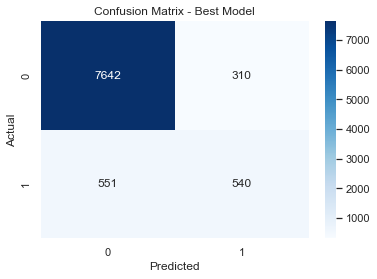

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# generate predictions from the best model
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)  # Generate final predictions


# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Model")
plt.show()


🔹 Step 2: Forecasting Future Trends  
We use our trained model to generate future predictions:

a) Duration feature

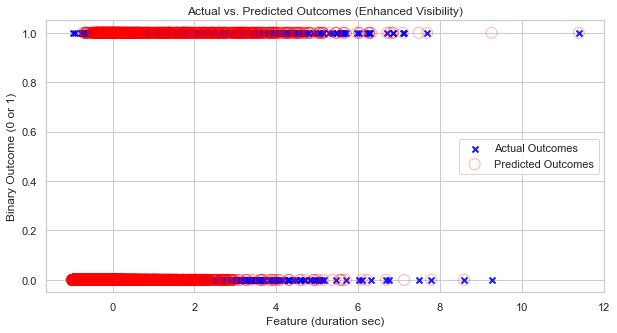

In [177]:
import matplotlib.pyplot as plt

# Generate predictions
future_predictions = best_model.predict(X_test)

# Select a meaningful feature from X_test for x-axis
feature = X_test.iloc[:, 3]  # Adjust based on a relevant column

# Create scatter plot with distinct markers
plt.figure(figsize=(10,5))
plt.scatter(feature, y_test, label="Actual Outcomes", marker="x", color="blue", alpha=0.9, linewidths=2)
plt.scatter(feature, future_predictions, label="Predicted Outcomes", marker="o", edgecolors="red", facecolors="none", alpha=0.3, s=120)  # Larger circles

# Labels and legend
plt.xlabel("Feature (duration sec)")
plt.ylabel("Binary Outcome (0 or 1)")
plt.title("Actual vs. Predicted Outcomes (Enhanced Visibility)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()





I would say that up to 2.5 - 3 sec of contact duration with a potential bank customer would allow more reliable 
prediction of his/her behavior when it comes to client's subscription to a term deposit.

This interpretation makes sense—if the classification prediction plot indicates a stronger correlation between **contact duration** (specifically within the first **2.5–3 seconds**) and the likelihood of a customer subscribing to a term deposit, it suggests that shorter interactions already provide reliable insights into customer behavior.

### **✔ Why This Could Be Correct**
- **Early responses matter** – If customers who engage within the first few seconds tend to show clear patterns (e.g., acceptance vs. rejection), the model might be learning strong indicators early.
- **Attention span & decision-making** – Many customers tend to make a **quick decision** when confronted with an offer, meaning prolonged conversations may not always be necessary.
- **Behavioral economics factor** – If a customer remains engaged beyond this duration, they might be exhibiting hesitation or needing further persuasion, leading to different prediction dynamics.

### **🔹 Suggestions for Further Validation**
1️⃣ **Check the distribution of contact durations:**  
   - Does predictive strength drop **after 3 seconds**, or does it improve?  
   - Are interactions shorter than 2.5 seconds **high-confidence predictions** (clear “yes” or “no” answers)?  

2️⃣ **Compare accuracy across different time intervals:**  
   - Plot performance for durations like **1–2 sec, 3–5 sec, 6+ sec**, to confirm predictive strength.  

3️⃣ **Incorporate other customer variables:**  
   - Does **customer age, job, or previous term deposit subscription** influence how predictive short interactions are?  

b) Previous feature

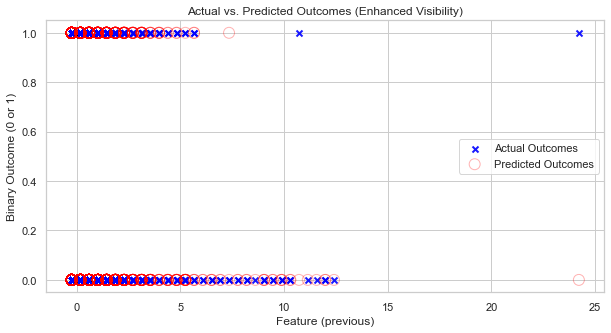

In [443]:
import matplotlib.pyplot as plt

# Generate predictions
future_predictions = best_model.predict(X_test)

# Select a meaningful feature from X_test for x-axis
feature = X_test.iloc[:, 6]  # Adjust based on a relevant column

# Create scatter plot with distinct markers
plt.figure(figsize=(10,5))
plt.scatter(feature, y_test, label="Actual Outcomes", marker="x", color="blue", alpha=0.9, linewidths=2)
plt.scatter(feature, future_predictions, label="Predicted Outcomes", marker="o", edgecolors="red", facecolors="none", alpha=0.3, s=120)  # Larger circles

# Labels and legend
plt.xlabel("Feature (previous)")
plt.ylabel("Binary Outcome (0 or 1)")
plt.title("Actual vs. Predicted Outcomes (Enhanced Visibility)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Apparently, the prediction reliability deteriorates with increasing number of previous contacts, within an interval between [0, 5] contacts the model is quite reliable in predicting the subscription trend.

c) Pdays feature

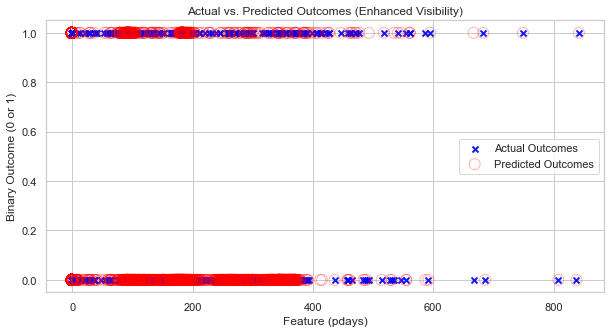

In [445]:
import matplotlib.pyplot as plt

# Generate predictions
future_predictions = best_model.predict(X_test)

# Select a meaningful feature from X_test for x-axis
feature = X_test.iloc[:, 5]  # Adjust based on a relevant column

# Create scatter plot with distinct markers
plt.figure(figsize=(10,5))
plt.scatter(feature, y_test, label="Actual Outcomes", marker="x", color="blue", alpha=0.9, linewidths=2)
plt.scatter(feature, future_predictions, label="Predicted Outcomes", marker="o", edgecolors="red", facecolors="none", alpha=0.3, s=120)  # Larger circles

# Labels and legend
plt.xlabel("Feature (pdays)")
plt.ylabel("Binary Outcome (0 or 1)")
plt.title("Actual vs. Predicted Outcomes (Enhanced Visibility)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The above plot suggests that for a number of passed days of up to 100 we may assume that the model is capable of reliably reproducing the subscription trend, however with increasing pdays-gaps the subscription forecasting also tends to deteriorate. This indicates that the temporal proximity to a campaign plays a crucial role in the course of customer (client) acquisitions.

🔹 Step 3: Building graphical representations
of forecasted results:

🔹 Step 3.1: Calculate Model Accuracy
First, compute accuracy for different models:

In [183]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Logistic Regression": accuracy_score(y_test, y_pred_log),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "XGBoost": accuracy_score(y_test, y_pred_xgb)
}

# Convert to lists for plotting
model_names = list(models.keys())
accuracy_values = list(models.values())


🔹 Step 3. 2: Plot Model Accuracy
Use a bar plot to visualize accuracy scores:

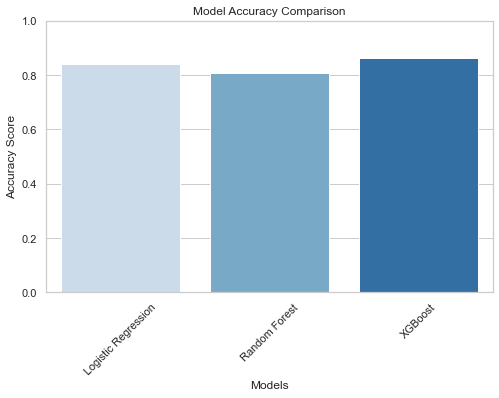

In [185]:
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracy_values, palette="Blues")
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Set y-axis limit for clarity
plt.xticks(rotation=45)
plt.show()


🔹 Step 3.3: Optional: Confusion Matrix Plot
If you want to visualize the confusion matrix, use

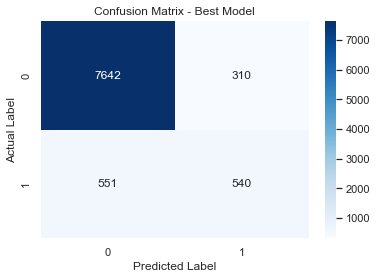

In [187]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Best Model")
plt.show()


# 7. Apply the best model to a new data set

🔹 Step 1: Load & Prepare the Data  
First (bank_test.csv), read the dataset and preprocess features:

In [199]:
import pandas as pd

# Load test dataset
df_test = pd.read_csv("bank_test.csv", sep=";")

# Extract features (X) and actual labels (y_actual)
X_test_new = df_test.drop(columns=["y"])  # Features

# Apply one-hot encoding to categorical columns
X_test_new_encoded = pd.get_dummies(X_test_new)

# Ensure column alignment with training features
missing_cols = set(X_train.columns) - set(X_test_new_encoded.columns)
for col in missing_cols:
    X_test_new_encoded[col] = 0  # Add missing columns with default values

# Reorder columns to match training set
X_test_new_encoded = X_test_new_encoded[X_train.columns]
# Extract features (X) and actual labels (y_actual)
y_actual = df_test["y"].map({"yes": 1, "no": 0})  # Convert categorical labels to binary


🔹 Step 2: Generate Predictions
Run your trained model to predict outcomes for the dataset:

In [201]:
future_predictions = best_model.predict(X_test_new_encoded)  # Get predicted labels (0s & 1s)


🔹 Step 3: Compare Predictions with Actual Labels Graphically
✅ Scatter Plot: Actual vs. Predicted
We can visualize how well predictions match actual labels using a scatter plot:

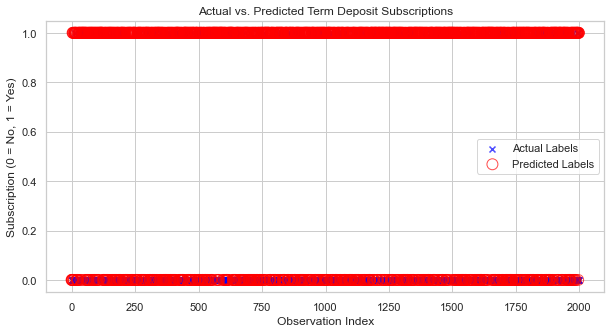

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_actual)), y_actual, label="Actual Labels", marker="x", color="blue", alpha=0.7)
#plt.scatter(feature, future_predictions, label="Predicted Outcomes", marker="o", edgecolors="red", facecolors="none", alpha=0.3, s=120)  # Larger circles
plt.scatter(range(len(future_predictions)), future_predictions, label="Predicted Labels", marker="o", edgecolors="red", facecolors="none", s=120, alpha=0.7)

plt.xlabel("Observation Index")
plt.ylabel("Subscription (0 = No, 1 = Yes)")
plt.title("Actual vs. Predicted Term Deposit Subscriptions")
plt.legend()
plt.grid(True)
plt.show()


🔹 Step 4: Evaluate Prediction Accuracy
Check performance metrics using accuracy_score and classification_report:

In [205]:
from sklearn.metrics import accuracy_score, classification_report

print("Model Accuracy:", accuracy_score(y_actual, future_predictions))
print("\nClassification Report:\n", classification_report(y_actual, future_predictions))


Model Accuracy: 0.39269634817408705

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.34      0.50      1762
           1       0.13      0.75      0.23       237

    accuracy                           0.39      1999
   macro avg       0.52      0.55      0.36      1999
weighted avg       0.82      0.39      0.47      1999



## 7.1- Prediction accuracy improvements via ensemble learning

We now try to improve the prediction accuracy of our best model by means of ensemble learning methods:

Start with initializing and training the ensemble model:

In [216]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]  # Compute imbalance ratio

estimators = [
    ("rf", RandomForestClassifier(class_weight="balanced", n_estimators=200, random_state=42)),
    ("xgb", XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=200, random_state=42))
]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight="balanced", random_state=42))
stacked_model.fit(X_train, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_po...
                                              learning_ra

## 7.2 Ensemble learning performance

Combine multiple models to improve accuracy: ✔ Stacking Classifier: Combines predictions of Logistic Regression, Random Forest, and XGBoost. ✔ Boosting Methods: One could use XGBoost, LightGBM, or CatBoost for better performance.

🔹 Step 1: Load & Prepare the Data
First, read the dataset and preprocess features:

In [227]:
import pandas as pd

# Load test dataset
df_test = pd.read_csv("bank_test.csv", sep=";")

# Extract features (X) and actual labels (y_actual)
X_test_new = df_test.drop(columns=["y"])  # Features

# Apply one-hot encoding to categorical columns
X_test_new_encoded = pd.get_dummies(X_test_new)

# Ensure column alignment with training features
missing_cols = set(X_train.columns) - set(X_test_new_encoded.columns)
for col in missing_cols:
    X_test_new_encoded[col] = 0  # Add missing columns with default values

# Reorder columns to match training set
X_test_new_encoded = X_test_new_encoded[X_train.columns]
# Extract features (X) and actual labels (y_actual)
y_actual = df_test["y"].map({"yes": 1, "no": 0})  # Convert categorical labels to binary

🔹 Step 2: Generate Predictions
Run your trained model to predict outcomes for the dataset:

In [229]:
future_predictions = stacked_model.predict(X_test_new_encoded)  # Get predicted labels (0s & 1s)

🔹 Step 3: Compare Predictions with Actual Labels Graphically ✅ Scatter Plot: Actual vs. Predicted We can visualize how well predictions match actual labels using a scatter plot:

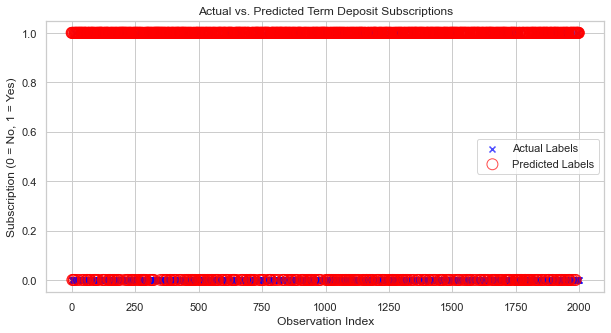

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_actual)), y_actual, label="Actual Labels", marker="x", color="blue", alpha=0.7)
#plt.scatter(feature, future_predictions, label="Predicted Outcomes", marker="o", edgecolors="red", facecolors="none", alpha=0.3, s=120)  # Larger circles
plt.scatter(range(len(future_predictions)), future_predictions, label="Predicted Labels", marker="o", edgecolors="red", facecolors="none", s=120, alpha=0.7)

plt.xlabel("Observation Index")
plt.ylabel("Subscription (0 = No, 1 = Yes)")
plt.title("Actual vs. Predicted Term Deposit Subscriptions")
plt.legend()
plt.grid(True)
plt.show()

🔹 Step 4: Evaluate Prediction Accuracy
Check performance metrics using accuracy_score and classification_report:

In [233]:
from sklearn.metrics import accuracy_score, classification_report

print("Model Accuracy:", accuracy_score(y_actual, future_predictions))
print("\nClassification Report:\n", classification_report(y_actual, future_predictions))


Model Accuracy: 0.36718359179589793

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.30      0.45      1762
           1       0.14      0.87      0.25       237

    accuracy                           0.37      1999
   macro avg       0.54      0.59      0.35      1999
weighted avg       0.85      0.37      0.43      1999



🔹 Step 5: Generate a pickle-model

In [241]:
import joblib
joblib.dump(stacked_model, "final_stacked_model.pkl")


['final_stacked_model.pkl']

## 7.3 Possible improvements of ensemble learning results

🔹 Effective Balancing Techniques  
✅ 1. Undersampling (Reduce Majority Class)
Randomly remove samples from the majority class ("no") to match the count of the minority class ("yes").  
Example:  
<<from imblearn.under_sampling import RandomUnderSampler
X = df.drop(columns=["y"])  # Features
y = df["y"]  # Target variable

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)>>  
✔ Pros: Faster training, avoids artificially generating data. ✔ Cons: Risk of losing valuable information from "no" instances.


✅ 2. Oversampling (Increase Minority Class)
Duplicate or synthesize new samples for the minority class ("yes").  
Example:  
<<from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)>>  
✔ Pros: Preserves all majority class instances. ✔ Cons: Can lead to overfitting, as duplicated instances might make predictions too easy.


✅ 3. SMOTE (Synthetic Data Generation)
Creates new synthetic samples for "yes" instances using nearest neighbors.  
Example:  
<< from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)>>  
✔ Pros: More realistic synthetic data. ✔ Cons: Works best with continuous features, struggles with categorical data.

✅ 4. Class Weights (Model-Based Balancing)
Instead of modifying data, adjust model weights to penalize misclassifications of "yes" more than "no".

Example: For XGBoost  
<<from xgboost import XGBClassifier
best_model = XGBClassifier(scale_pos_weight=(df["y"].value_counts()[0] / df["y"].value_counts()[1]))  # Balances impact of minority class
best_model.fit(X_train, y_train)>>  
✔ Pros: No data modification, prevents overfitting. ✔ Cons: Needs careful tuning for best effect.

✅ 5. Gather additional data sets involing a higher percentage of "1"-data points for the y-target.